# 07-3 신경망 모델 훈련
### 인공 신경망 모델을 훈련하는 모범 사례와 필요한 도구들 --> 텐서플로와 케라스 API 익숙해지기!
---
<br/>
💡용어 정리💡  
❓ 손실함수 ➡️ 인공 신경망 모델이 최적화하는 대상은 손실 함수!! (정확도XX)  
 --> 손실 감소에 비례하여 정확도가 높아지는 경우도 존재함  
❓ 드롭아웃 ➡️ 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 껴서 과대적합을 막는 방식  
 1. 뉴런은 랜덤하게 드롭아웃됨  
  --> 하이퍼파라미터로, 지정해야함  
 2. 뉴런이 랜덤하게 드롭되면서 특정 뉴런에 과하게 의존하는 것 방지  
 3. 일부 유런의 출력이 0이 될 수 있음  
 4. 더 안정적이고, 탄탄한 예측 생성 가능!!  
---
 1. 드롭아웃이 적용된 2개의 신경망을 적용해 훈련  
 2. 마치 앙상블 기법을 쓰는듯한 효과! 

❓ 콜백 ➡️ 훈련 과정 중간에 다른 작업을 수행할 수 있게 하는 객체  
 --> keras.callbacks
❓ 조기종료 ➡️ 과대적합이 커지기 전에 훈련을 미리 종료하는 것  
 --> 훈련 에포크 횟수를 제한하는 역할!  

### 손실곡선

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# MNIST 데이터 로드
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

# 데이터셋 범위 0~!로 조정
train_scaled = train_input / 255.0

# 훈련 세트 테스트 세트 분할
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
def model_fn(a_layer=None):
  # 모델 생성
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
# verbose --> 훈련 과정 출력 조절! (기본값=1), 그래프 등 출력 안됨!! 
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

**fit()의 결과를 history 변수에 담아서 출력!**  
 --> 손실과 정확도가 포함됨!

In [5]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


**손실 산점도**

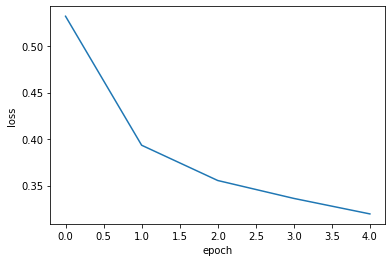

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

**정확도 산점도**

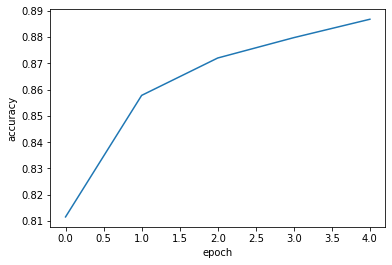

In [7]:
plt.plot(history.history['accuracy'])

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

**에포크를 20으로 늘인 뒤, 재훈련!**  
 --> 에포크 횟수의 증가에 비례하여 손실은 감소함  왜??  

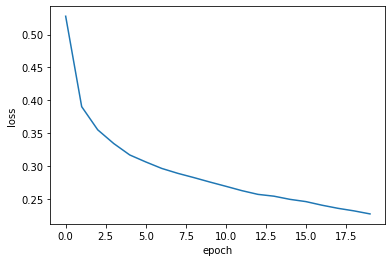

In [8]:
model = model_fn()

# 에포크 횟수를 20으로 증가시킨 뒤, 모델 재훈련 --> 손실 그래프 생성
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

**에포크마다 검증 손실 계산**  
- validation_data() --> 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달!!  

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

**위에서 담은 history 변수에서의 결과 출력**

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**훈련 손실과 검증 손실을 한 그래프에 작성 후 비교! --> for 과대/과소적합 문제 시각화**  
- 훈련 손실은 꾸준히 감소 --> 과대적합 모델  

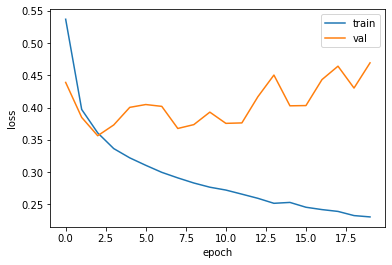

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'val'])

plt.show()

**옵티마이저 변경 기본(RMSprop)->Adam**  
- 과대적합 감소를 위해 --> 옵티마이저 변경  
- 모델 재훈련  
- 훈련 손실, 검증 손실 그래프  
 --> 과대적합이 훨씬 줄었음!!

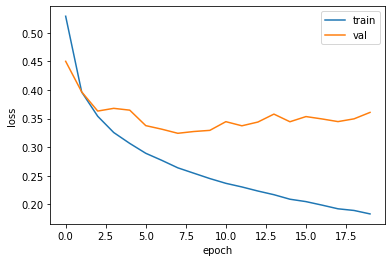

In [12]:
model = model_fn()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

### 드롭아웃

**Dropout() 층 추가**  
- 은닉층 뒤에 추가된 드롭아웃 층 확인!  
- 모델 파라미터가 없음  
- 입력과 출력의 크기가 같음  
- 일부 뉴런의 출력을 0으로 만들지만 --> 전체 출력 배열의 크기를 바꾸진XX  

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


**은닉층을 추가한 채 모델 재훈련 및 손실함수 출력**  
- 훈련이 끝난 뒤, 평가나 예측 수행시에는 드롭아웃 적용XX  
 (텐서플로와 케라스가 알아서 적용하지 않음!)  
- 10번째 epoch 이후부터는 다시 과대적합!  
 따라서, 에포크 횟수를 다시 지정한 뒤 재훈련(10으로)  

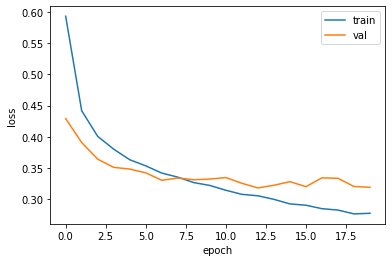

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

### 모델 저장과 복원

**에포크 횟수 변경 20->10**

In [15]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

**keras.save_weights()**  
- 훈련된 모델의 파라미터를 저장하는 함수  
- .h5는 확장자  

In [16]:
model.save_weights('model-weights.h5')

**keras.save()**  
- 모델 구조와 모델 파라미터를 함께 저장하는 함수  

In [17]:
model.save('model-whole.h5')

**.h5 확장자 리스트 출력**  
- 셀 명령 실행 시, 앞에 ! 사용  

In [18]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Mar 25 11:13 model-weights.h5
-rw-r--r-- 1 root root 982664 Mar 25 11:13 model-whole.h5


#### 실험(1)  
- 훈련을 하지 않은 새로운 모델을 만든 후, model-weights.h5파일에서 훈련된 모델 파라미터를 읽은 후 사용  
- load_weights()

In [19]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

**위 모델의 검증 정확도 확인**

In [20]:
import numpy as np
# argmax() --> 배열에서 가장 큰 값의 인덱스 반환
# axis=-1 --> 열을 따라 각 행의 최댓값의 인덱스 반환
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8853333333333333


#### 실험(2)  
- 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도 출력  
- load_model() --> 모델이 저장된 파일 로드  

In [21]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3196 - accuracy: 0.8853


[0.31956684589385986, 0.8853333592414856]

### 콜백  
- ModelCheckpoint --> 에포크마다 모델 저장

In [23]:
# 모델 생성
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# save_best_only=True --> 가장 낮은 검증 점수를 만드는 모델 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)

# fit() 에 callbacks 매개변수에 리스트로 전달하여 콜백 사용!
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [24]:
# 최상의 검증 점수를 낸 모델이 저장된 파일
model = keras.models.load_model('best-model.h5') 
# 예측 수행
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3190 - accuracy: 0.8842


[0.31899720430374146, 0.8841666579246521]

### 조기종료  
- patience=2 --> 2번 연속 검증 점수가 향상되지 않으면 훈련 중지!  
- restore_best_weights=True --> 가장 낮은 검증 손실을 낸 모델 파라미터 리턴

In [27]:
# 가장 낮은 검증 손실의 모델을 파일에 저장 -> 검증 손실이 다시 상승할 때 훈련 중지
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

# ModelCheckpoint 콜백 사용
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

# EarlyStopping 콜백 사용
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

**최상의 모델의 에포크 확인**

In [28]:
# 에포크 횟수는 0부터 카운팅! --> 7번째 에포크에서 훈련이 중지됨
# patience를 2로 지정했으므로 --> 5번째 에포크가 최상의 모델!
print(early_stopping_cb.stopped_epoch)

6


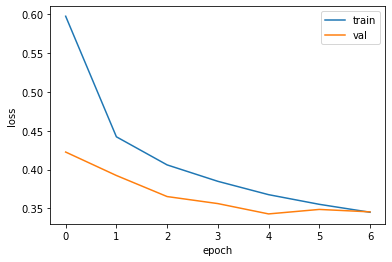

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

In [30]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.3429 - accuracy: 0.8773


[0.3428845703601837, 0.8772500157356262]